In [1]:
import json
import pickle
import random

import pandas as pd

# Create single dataset

In [2]:
with open('../data/PAT-singlehop.json', 'r') as file:
    pat_singlehop = json.load(file)

with open('../data/PAT-singlehop-special-attention.json', 'r') as file:
    pat_singlehop_attention = json.load(file)
    
with open('../data/PAT-multihop.json', 'r') as file:
    pat_multihop = json.load(file)

In [4]:
ids = []

for _, info in pat_singlehop.items():
    ids.append(info['uniq_id'])

for _, info in pat_singlehop_attention.items():
    ids.append(info['uniq_id'])

for _, info in pat_multihop.items():
    ids.append(info['uniq_id'])

print('Total questions:', len(pat_singlehop) + len(pat_multihop))
print('Total ids:', len(ids))
print('Unique ids:', len(set(ids)))
print('Largest id:', max(ids))

Total questions: 6011
Total ids: 7421
Unique ids: 3367
Largest id: 6306


In [5]:
list_of_uniq_ids = set()
dataset = {}

def gen_unique_id(id):
    id = max(list_of_uniq_ids)
    while id in list_of_uniq_ids:
        id += 1
    return id

for question, info in pat_singlehop.items():
    # assert info['uniq_id'] not in list_of_uniq_ids and type(info['uniq_id']) == int
    if info['uniq_id'] not in list_of_uniq_ids:
        id = info['uniq_id']
    else:
        id = gen_unique_id(6307)
    id = int(id)
    
    list_of_uniq_ids.add(id)
    data = info.copy()
    data['attention'] = info['question'] in pat_singlehop_attention.keys()
    dataset[id] = data.copy()


for question, info in pat_multihop.items():
    # assert info['uniq_id'] not in list_of_uniq_ids and type(info['uniq_id']) == int
    if info['uniq_id'] not in list_of_uniq_ids:
        id = info['uniq_id']
    else:
        id = gen_unique_id(6307)
    id = int(id)
    
    list_of_uniq_ids.add(id)
    data = info.copy()
    data['attention'] = False
    dataset[id] = data.copy()

with open('../data/dataset.json', 'w') as f:
    json.dump(dataset, f)

## Prepare GPT

In [7]:
with open('../data/dataset.json', 'r') as f:
    dataset = json.load(f)

In [8]:
from functions import process_questions_concurrently
from openai import OpenAI

MODEL_NAME = 'gpt-4o'
client = OpenAI(api_key='')

In [4]:
sample_questions = {k: dataset.get(k) for k in random.sample(list(dataset.keys()), 60) }

### One question per request

In [5]:
system_prompt = """You are an expert assistant in Open-Domain Question Answering. Answer the following question based on your knowledge and any external materials or sources available to you, adhering to these guidelines:

**Guidelines for Answering**:
- Provide a concise, factual answer using only relevant information from both internal knowledge and external sources.
- Avoid paraphrasing the question; answer only with the information requested.
- Use only singular nouns or names in their base form, avoiding declensions and articles.
- Use no punctuation, commas, or periods.
- If multiple answers exist, separate them with a special token (e.g., "|") and sort them by relevance (the most famous one first).
- If the answer is unknown or ambiguous, make a best guess based on common or widely accepted knowledge from available sources, but avoid speculation. Use "Unknown" only if no answer can be reasonably provided from any source.

**Examples**:
Question: What is the largest planet in solar system?
Answer: Jupyter

Question: Who starred in the movie Titanic?
Answer: Leonardo DiCaprio | Kate Winslet | Billy Zane | Kathy Bates

Question: When did World War II start?
Answer: 01.09.1939"""


question_prompt = lambda question: f"Question: {question}\nAnswer: "

In [6]:
question_batch = [(id, question_prompt(info['question'])) for id, info in sample_questions.items()]
result_batch_single = process_questions_concurrently(question_batch, system_prompt, MODEL_NAME, client, max_workers=32)
result_single_dict = {id: info['result'] for id, info in result_batch_single.items()}

In [7]:
assert set(result_single_dict.keys()) == set([str(id) for id in sample_questions.keys()])

In [8]:
# Tokens used per 60 questions
sum([info['usage']['total_tokens'] for info in result_batch_single.values()])

16742

### Multiple questions per request

In [14]:
system_prompt = """You are an expert assistant in Open-Domain Question Answering. Answer the following list of questions based on your knowledge and any external materials or sources available to you, adhering to these guidelines:

**Guidelines for Answering**:
- Provide a concise, factual answer for each question using relevant information from both internal knowledge and external sources.
- Treat each question as independent, even though they are listed together.
- Each answer should strictly start with the unique ID associated with its question.
- Use only singular nouns or names in their base form, avoiding declensions and articles.
- Use no punctuation, commas, or periods.
- If multiple answers exist, separate them with a special token (e.g., "|") and sort them by relevance (the most famous one first).
- If the answer is unknown or ambiguous, make a best guess based on common or widely accepted knowledge from available sources, but avoid speculation. Use "Unknown" only if no answer can reasonably be provided from any source.

**Example**:

Questions:
1782. What is the largest planet in solar system?
78. Who starred in the movie Titanic?
9231. When did World War II start?

Answers:
1782. Jupyter
78. Leonardo DiCaprio | Kate Winslet | Billy Zane | Kathy Bates
9231. 01.09.1939
"""

In [15]:
def create_prompt_for_batch(batch):
    prompt = 'Questions:\n'
    for (id, question) in batch:
        prompt += f"{str(id)}. {question}\n"

    prompt += '\nAnswers:\n'

    return prompt

def unpack_batch(result):
    result_dict = {}
    
    # Split the data by lines and process each line
    for line in result.splitlines():
        key, value = line.split(". ", 1)  # Split at the first occurrence of ". "
        result_dict[key] = value.strip()  # Convert key to int and strip any whitespace from value

    return result_dict

In [16]:
question_batch = [(id, info['question']) for id, info in sample_questions.items()]
question_batch = [(0, create_prompt_for_batch(question_batch))]
result_batch_multiple = process_questions_concurrently(question_batch, system_prompt, MODEL_NAME, client)
result_multiple_dict = unpack_batch(result_batch_multiple[0]['result'])

In [17]:
assert set(result_multiple_dict.keys()) == set([str(id) for id in sample_questions.keys()])

In [18]:
# Total tokens per 60 questions
result_batch_multiple[0]['usage']['total_tokens']

1740

### Compare

In [21]:
compare_table = pd.DataFrame({
    'Single': pd.Series(result_single_dict),
    'Multiple': pd.Series(result_multiple_dict),
    'Gold': pd.Series({k: ' | '.join(info['text answers']) for k, info in sample_questions.items()})
})

# compare_table.to_csv('artefacts/sample_compare_table.csv', index=False)

In [24]:
(compare_table == 'Unknown').sum()

Single      25
Multiple    32
Gold         0
dtype: int64

In [27]:
print('Single accuracy:', (compare_table['Single'] == compare_table['Gold']).sum())
print('Multiple accuracy:', (compare_table['Multiple'] == compare_table['Gold']).sum())

Single accuracy: 5
Multiple accuracy: 11


In [186]:
compare_table 

,Question,attention,text answers,prediction
376,Which team does Cristiano Ronaldo play for cur...,True,"[Al-Nassr, Portugal men's national football team]",[Al Nassr]
377,Which team did Cristiano Ronaldo play for last...,False,[Manchester United F.C.],[Manchester United]
378,Which team does Neymar play for currently?,True,"[Al Hilal SFC, Brazil men's national football ...",[Al Hilal]
379,Which team did Neymar play for last before joi...,False,[Paris Saint-Germain F.C.],[Paris Saint-Germain]
390,Which team does Arash Roshanipour play for cur...,True,[Saba Qom F.C.],[Ezz Steel]
...,...,...,...,...
3286,Who is the spouse of the previous head of the ...,False,[Elvira Fernández],[Sonsoles Espinosa]
3287,Who did the current head of the government of ...,False,[Michel Bouchez],[Unknown]
3288,Who did the previous head of the government of...,False,[Alexandre Bernard],[Unknown]
3289,Who did the current head of the government of ...,False,[Federico Sboarina],[Federico Sboarina]


# Process

In [15]:
from functions import process_questions_concurrently
from openai import OpenAI

MODEL_NAME = 'gpt-4o'
client = OpenAI(api_key='')

In [128]:
def create_prompt_for_batch(batch):
    prompt = 'Questions:\n'
    for (id, question) in batch:
        prompt += f"{str(id)}. {question}\n"

    prompt += '\nAnswers:\n'

    return prompt

def unpack_batch(result):
    result_dict = {}
    
    # Split the data by lines and process each line
    for line in result.splitlines():
        if '.' in line:
            key, value = line.split(". ", 1)  # Split at the first occurrence of ". "
            result_dict[key] = value.strip()  # Convert key to int and strip any whitespace from value

    return result_dict

In [11]:
system_prompt = """You are an expert assistant in Open-Domain Question Answering. Answer the following list of questions based on your knowledge and any external materials or sources available to you, adhering to these guidelines:

**Guidelines for Answering**:
- Provide a concise, factual answer for each question using relevant information from both internal knowledge and external sources.
- Treat each question as independent, even though they are listed together.
- Each answer should strictly start with the unique ID associated with its question.
- Use only singular nouns or names in their base form, avoiding declensions and articles.
- Use no punctuation, commas, or periods.
- If multiple answers exist, separate them with a special token (e.g., "|") and sort them by relevance (the most famous one first).
- If the answer is unknown or ambiguous, make a best guess based on common or widely accepted knowledge from available sources, but avoid speculation. Use "Unknown" only if no answer can reasonably be provided from any source.

**Example**:

Questions:
1782. What is the largest planet in solar system?
78. Who starred in the movie Titanic?
9231. When did World War II start?

Answers:
1782. Jupyter
78. Leonardo DiCaprio | Kate Winslet | Billy Zane | Kathy Bates
9231. 01.09.1939
"""

In [80]:
chunk_size = 64

questions_to_process = []
batch_id_info = {}

for i, k in enumerate(range(0, len(dataset), chunk_size)):
    batch_ids = unique_ids[k:k + chunk_size]
    batch_questions = [(id, info['question']) for id, info in dataset.items() if id in batch_ids]

    batch = create_prompt_for_batch(batch_questions)
    questions_to_process += [(i, batch)]
    batch_id_info[i] = batch_questions.copy()

In [134]:
dataset_batched_answers = process_questions_concurrently(questions_to_process, system_prompt, MODEL_NAME, client)

In [135]:
for i, info in dataset_batched_answers.items():
    if info.get('finish_reason', None) != 'stop' or info['error'] is not None:
        print(f'Batch {i} was not completed!')
    else:
        try:
            if set(unpack_batch(info.get('result', {})).keys()) == set([str(id) for id, _ in batch_id_info[i]]):
                clean_answers[i] = info.copy()
            else:
                print(f'Batch {i} was not completed!')
        except:
            print(f'Batch {i} was not completed!')
            continue

with open('artefacts/dataset_batched_answers.json', 'w') as f:
    json.dump(clean_answers, f)

In [140]:
dataset_answers = {}

for id, info in clean_answers.items():
    dataset_answers.update(unpack_batch(info.get('result', {})))

assert set(dataset_answers.keys()) == set(dataset.keys())

with open('artefacts/dataset_answers.json', 'w') as f:
    json.dump(dataset_answers, f)

# Check answers

In [141]:
with open('artefacts/dataset_answers.json', 'r') as f:
    dataset_answers = json.load(f)

In [157]:
df = pd.DataFrame.from_dict(dataset, orient='index')

# Select the required columns and rename them
result_table = df[['question', 'attention', 'text answers',]].copy()

# Rename columns as specified
result_table = result_table.rename(columns={
    'question': 'Question',
    'text answers': 'text answers'
})

result_table['prediction'] = pd.Series({k: v.split(' | ') for k, v in dataset_answers.items()})

In [158]:
result_table

,Question,attention,text answers,prediction
376,Which team does Cristiano Ronaldo play for cur...,True,"[Al-Nassr, Portugal men's national football team]",[Al Nassr]
377,Which team did Cristiano Ronaldo play for last...,False,[Manchester United F.C.],[Manchester United]
378,Which team does Neymar play for currently?,True,"[Al Hilal SFC, Brazil men's national football ...",[Al Hilal]
379,Which team did Neymar play for last before joi...,False,[Paris Saint-Germain F.C.],[Paris Saint-Germain]
390,Which team does Arash Roshanipour play for cur...,True,[Saba Qom F.C.],[Ezz Steel]
...,...,...,...,...
3286,Who is the spouse of the previous head of the ...,False,[Elvira Fernández],[Sonsoles Espinosa]
3287,Who did the current head of the government of ...,False,[Michel Bouchez],[Unknown]
3288,Who did the previous head of the government of...,False,[Alexandre Bernard],[Unknown]
3289,Who did the current head of the government of ...,False,[Federico Sboarina],[Federico Sboarina]


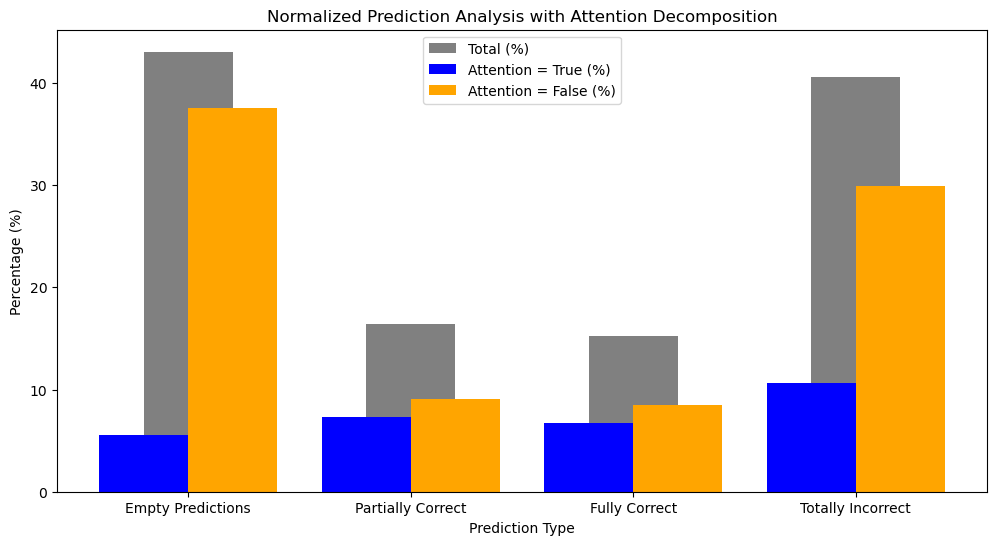

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data setup
# Assuming `compare_table` is already loaded with columns:
# ['Question', 'text answers', 'attention', 'Top-1 from text answers', 'prediction']

compare_table = result_table.copy()

# 1. Number of predictions with answer 'Unknown', None, [] or ''
def count_empty_predictions(row):
    return row in [['Unknown'], [None], [], ['']]
total_questions = compare_table.shape[0]

empty_predictions_count = compare_table['prediction'].apply(count_empty_predictions).sum()

# Decompose empty predictions based on attention flag
empty_with_attention = compare_table[compare_table['attention'] & compare_table['prediction'].apply(count_empty_predictions)].shape[0]
empty_without_attention = empty_predictions_count - empty_with_attention

# 2. Number of correctly guessed predictions (at least one element from prediction list is in text answers)
def partially_correct(row):
    return any(pred in row['text answers'] for pred in row['prediction']) if isinstance(row['prediction'], list) else False

partial_correct_count = compare_table.apply(partially_correct, axis=1).sum()

# Decompose partially correct predictions based on attention flag
partial_correct_with_attention = compare_table[compare_table['attention'] & compare_table.apply(partially_correct, axis=1)].shape[0]
partial_correct_without_attention = partial_correct_count - partial_correct_with_attention

# 3. Number of correctly guessed predictions (whole list intersection only considered as correctly guessed)
def fully_correct(row):
    return set(row['prediction']) == set(row['text answers']) if isinstance(row['prediction'], list) else False

full_correct_count = compare_table.apply(fully_correct, axis=1).sum()

# Decompose fully correct predictions based on attention flag
full_correct_with_attention = compare_table[compare_table['attention'] & compare_table.apply(fully_correct, axis=1)].shape[0]
full_correct_without_attention = full_correct_count - full_correct_with_attention

# 4. Number of totally incorrect predictions (no overlap)
def totally_incorrect(row):
    is_empty = count_empty_predictions(row['prediction'])
    if is_empty:
        return False
    return not any(pred in row['text answers'] for pred in row['prediction']) if isinstance(row['prediction'], list) else True

totally_incorrect_count = compare_table.apply(totally_incorrect, axis=1).sum()

# Decompose totally incorrect predictions based on attention flag
totally_incorrect_with_attention = compare_table[compare_table['attention'] & compare_table.apply(totally_incorrect, axis=1)].shape[0]
totally_incorrect_without_attention = totally_incorrect_count - totally_incorrect_with_attention

# Normalizing counts to percentages
labels = ['Empty Predictions', 'Partially Correct', 'Fully Correct', 'Totally Incorrect']
total_counts = [empty_predictions_count, partial_correct_count, full_correct_count, totally_incorrect_count]
attention_counts = [empty_with_attention, partial_correct_with_attention, full_correct_with_attention, totally_incorrect_with_attention]
no_attention_counts = [empty_without_attention, partial_correct_without_attention, full_correct_without_attention, totally_incorrect_without_attention]

# Normalize to percentage
total_counts = [count / total_questions * 100 for count in total_counts]
attention_counts = [count / total_questions * 100 for count in attention_counts]
no_attention_counts = [count / total_questions * 100 for count in no_attention_counts]

# Plotting the normalized bar charts
x = range(len(labels))
plt.figure(figsize=(12, 6))

plt.bar(x, total_counts, width=0.4, label='Total (%)', color='gray')
plt.bar([p - 0.2 for p in x], attention_counts, width=0.4, label='Attention = True (%)', color='blue')
plt.bar([p + 0.2 for p in x], no_attention_counts, width=0.4, label='Attention = False (%)', color='orange')

plt.xlabel('Prediction Type')
plt.ylabel('Percentage (%)')
plt.title('Normalized Prediction Analysis with Attention Decomposition')
plt.xticks(x, labels)
plt.legend()
plt.show()